**Note:** This notebook might not run properly on a small cluster. It was tested on a 5-node cluster with e2-highmem-2 machines.

Update the bucket name to your own:

In [1]:
data = "gs://is843/data/"

# Exploratory Data Analysis or Data Profiling

Data profiling should address the following topics:

* Completeness: How complete is the data? What percentage of records has missing or null values?
* Uniqueness: How many unique values does an attribute have? Does the attribute(s) that is supposed to be the unique key, have all unique values?
* Distribution: What is the distribution of values of an attribute?
* Basic statistics: The mean, standard deviation, minimum, maximum for numerical attributes.
* Pattern matching: What patterns are matched by data values of an attribute?
* Outliers: Are there outliers in the numerical data?
* Correlation: What is the correlation between two given attributes? This kind of profiling may be important for feature analysis prior to building predictive models.

The advantages of EDA can be summarized as:

* Find out what is in the data before using it
* Get data quality metrics
* Get an early assessment on the difficulties in creating business rules
* Input the a subsequent cleansing step
* Discover value patterns and distributions
* Understanding data challenges early to avoid delays and cost overruns
* Improve the ability to search the data

Following statistics are typically calculated:

|Statistics|Description|
|--|--|
|Count|	Using the Dataframe describe method|
|Average|	Using the Dataframe describe method|
|Minimum|	Using the Dataframe describe method|
|Maximum|	Using the Dataframe describe method|
|Standard deviation|	Using the Dataframe describe method|
|Missing values|	Using the Dataframe filter method|
|Density|	Ratio calculation|
|Min. string length|	Using the Dataframe expr, groupBy, agg, min, max, avg methods|
|Max. string length|	Using the Dataframe expr, groupBy, agg, min, max, avg methods|
|\# uniques values|	Using the Dataframe distinct and count methods|
|Top 100 of most frequent values|	Using the Dataframe groupBy, count, filter, orderBy, limit methods|


Source: http://www.bigdatareflections.net/blog/?p=111

# City of Chicago: Reported Crime Dataset - Since 2001

**Data Source:** Dataset was downloaded from [data.cityofchicago.org](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)

This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. The dataset is being updated daily; the data used in this notebook was updated on March 21, 2021. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.



**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|ID|Unique identifier for the record.|String|
|Case Number|The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.|String|
|Date|Date when the incident occurred. this is sometimes a best estimate.|Timestamp|
|Block|The partially redacted address where the incident occurred, placing it on the same block as the actual address.|String|
|IUCR|The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.|String|
|Primary Type|The primary description of the IUCR code.|String|
|Description|The secondary description of the IUCR code, a subcategory of the primary description.|String|
|Location Description|Description of the location where the incident occurred.|String|
|Arrest|Indicates whether an arrest was made.|Boolean|
|Domestic|Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.|Boolean|
|Beat|Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.|String|
|District|Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.|String|
|Ward|The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.|String|
|Community Area|Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.|String|
|FBI Code|Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).|String|
|X Coordinate|The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.|Double|
|Y Coordinate|The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.|Double|
|Year|Year the incident occurred.|Integer|
|Updated On|Date and time the record was last updated.|Date|
|Latitude|The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.|Double|
|Longitude|The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.|Double|
|Location|The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.|String|


## Some of the questions one could ask and find answers to from this dataset:
* How has crime in Chicago changed across years? 
* Was 2016 really the bloodiest year in two decades?
* Are some types of crimes more likely to happen in specific locations or specific time of the day or specific day of the week than other types of crimes?

### Loading the data into a Spark DataFrame
We will first define our schema:

In [2]:
from pyspark.sql import functions as F

from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType)

crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", StringType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

Create crimes dataframe by providing the schema above:

In [3]:
crimes = spark.read.format("csv")\
  .option("header", "true")\
  .schema(crimes_schema)\
  .load(data + "chicago-crimes/Crimes_2001_to_present.csv")

crimes.printSchema()
crimes.show(1, False)

root
 |-- ID: string (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- CommunityArea: string (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: double (nullable = true)
 |-- YCoordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



+--------+----------+----------------------+---------------+----+-----------+-----------------------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+----------------------+------------+-------------+-----------------------------+
|ID      |CaseNumber|Date                  |Block          |IUCR|PrimaryType|Description            |LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn             |Latitude    |Longitude    |Location                     |
+--------+----------+----------------------+---------------+----+-----------+-----------------------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+----------------------+------------+-------------+-----------------------------+
|10224738|HY411648  |09/05/2015 01:30:00 PM|043XX S WOOD ST|0486|BATTERY    |DOMESTIC BATTERY SIMPLE|RESIDENCE          |false |true    

### Caching the crimes DataFrame

In [5]:
crimes = crimes.repartition(20)
print("data was re-partitioned to {} partitions!".format(crimes.rdd.getNumPartitions()))

# Setting the number of shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "20")

# Caching the DataFrame
crimes.cache()

data was re-partitioned to 20 partitions!


DataFrame[ID: string, CaseNumber: string, Date: string, Block: string, IUCR: string, PrimaryType: string, Description: string, LocationDescription: string, Arrest: boolean, Domestic: boolean, Beat: string, District: string, Ward: string, CommunityArea: string, FBICode: string, XCoordinate: double, YCoordinate: double, Year: int, UpdatedOn: string, Latitude: double, Longitude: double, Location: string]

In [6]:
print(" The crimes DataFrame has {} records".format(crimes.count()))

 The crimes DataFrame has 7509990 records


### Dropping columns that we will not be using in our analysis

In [7]:
crimes = crimes.drop('CaseNumber', 'IUCR', 'XCoordinate', 'YCoordinate', 'UpdatedOn','Year', 'Location')

### Converting Date to timestamp

In [8]:
crimes = crimes.withColumn("Date", F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'))

### Dropping duplicates if any?

In [9]:
crimes = crimes.drop_duplicates()
crimes.cache()

DataFrame[ID: string, Date: timestamp, Block: string, PrimaryType: string, Description: string, LocationDescription: string, Arrest: boolean, Domestic: boolean, Beat: string, District: string, Ward: string, CommunityArea: string, FBICode: string, Latitude: double, Longitude: double]

In [10]:
crimes.count()

7509990

Since this is a clean and well-maintained dataset there are no duplicates! The number matches the one before dropping duplicates!

### Renaming column names:

In [11]:
crimes = crimes.withColumnRenamed("Latitude", "Lat")\
  .withColumnRenamed("Longitude", "Lon")

In [12]:
crimes.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- CommunityArea: string (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)



In [13]:
crimes.limit(3).toPandas()

,ID,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Beat,District,Ward,CommunityArea,FBICode,Lat,Lon
0,11356613,2018-06-23 03:00:00,037XX W GRENSHAW ST,ASSAULT,SIMPLE,APARTMENT,False,True,1133,011,24,29,08A,41.867164,-87.718625
1,1321559,2001-01-07 03:00:00,054XX S HYDE PARK BL,BATTERY,SIMPLE,RESIDENCE,False,True,2132,002,None,None,08B,41.795423,-87.584103
2,11109369,2017-10-04 10:30:00,039XX W BELMONT AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,False,2523,025,31,21,08B,41.939104,-87.726351


### Summary of the columns using `describe()`:

In [14]:
crimes.describe(['Lat', 'Lon']).show()

+-------+-------------------+-------------------+
|summary|                Lat|                Lon|
+-------+-------------------+-------------------+
|  count|            7431755|            7431755|
|   mean|  41.84207194709893| -87.67160112804963|
| stddev|0.08879854707374062|0.06108716902447201|
|    min|       36.619446395|      -91.686565684|
|    max|       42.022910333|      -87.524529378|
+-------+-------------------+-------------------+



### Date range:

In [15]:
crimes.selectExpr("min(Date)", "max(Date)").show()

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2022-03-19 23:59:00|
+-------------------+-------------------+



In [16]:
crimes_per_year = crimes.groupBy(F.year("Date").alias("Year")).agg(F.count("ID").alias("crimes_count")).orderBy("Year")
crimes_per_year.show(25)

+----+------------+
|Year|crimes_count|
+----+------------+
|2001|      485826|
|2002|      486783|
|2003|      475971|
|2004|      469412|
|2005|      453756|
|2006|      448159|
|2007|      437071|
|2008|      427143|
|2009|      392808|
|2010|      370458|
|2011|      351939|
|2012|      336227|
|2013|      307412|
|2014|      275686|
|2015|      264640|
|2016|      269686|
|2017|      268926|
|2018|      268570|
|2019|      260977|
|2020|      211638|
|2021|      206508|
|2022|       40394|
+----+------------+



### Primary crime types
How many primary crime types are there?

In [17]:
crimes.select("PrimaryType").distinct().count()

36

Rank them based on their frequency:

In [18]:
crimes.groupBy("PrimaryType").agg(F.count('ID').alias("Count"))\
  .orderBy(F.desc("Count")).show(35, False)

+---------------------------------+-------+
|PrimaryType                      |Count  |
+---------------------------------+-------+
|THEFT                            |1580856|
|BATTERY                          |1377415|
|CRIMINAL DAMAGE                  |856016 |
|NARCOTICS                        |741397 |
|ASSAULT                          |483907 |
|OTHER OFFENSE                    |467131 |
|BURGLARY                         |416077 |
|MOTOR VEHICLE THEFT              |347799 |
|DECEPTIVE PRACTICE               |325298 |
|ROBBERY                          |282377 |
|CRIMINAL TRESPASS                |209416 |
|WEAPONS VIOLATION                |96630  |
|PROSTITUTION                     |69529  |
|OFFENSE INVOLVING CHILDREN       |53228  |
|PUBLIC PEACE VIOLATION           |51474  |
|SEX OFFENSE                      |29179  |
|CRIM SEXUAL ASSAULT              |27767  |
|INTERFERENCE WITH PUBLIC OFFICER |17891  |
|LIQUOR LAW VIOLATION             |14665  |
|GAMBLING                       

### Domestic assaults
How many domestic assaults are there?

In [19]:
crimes.filter((crimes["PrimaryType"] == "ASSAULT") & (crimes["Domestic"] == True)).count()

109787

### Arrest
How often these crimes resulted in an arrest?

In [20]:
total_arrests = crimes.where(F.col("Arrest") == True).count()
total_crime = crimes.count()

print("{}% Arrests.".format(round(total_arrests/total_crime*100, 1)))

26.7% Arrests.


In [21]:
arrests_per_year = crimes.where(F.col("Arrest") == True).groupBy(F.year("Date").alias("Year"))\
  .agg(F.count("ID").alias("arrests_count")).orderBy("Year")

arrest_rate = crimes_per_year.join(arrests_per_year, "Year")\
  .withColumn("arrest_rate", F.round(F.col("arrests_count")/F.col("crimes_count")*100, 2))\
  .orderBy("Year")

arrest_rate.show(25)

+----+------------+-------------+-----------+
|Year|crimes_count|arrests_count|arrest_rate|
+----+------------+-------------+-----------+
|2001|      485826|       141926|      29.21|
|2002|      486783|       141561|      29.08|
|2003|      475971|       141584|      29.75|
|2004|      469412|       144695|      30.82|
|2005|      453756|       140917|      31.06|
|2006|      448159|       135410|      30.21|
|2007|      437071|       131872|      30.17|
|2008|      427143|       110008|      25.75|
|2009|      392808|       110817|      28.21|
|2010|      370458|       100528|      27.14|
|2011|      351939|        96274|      27.36|
|2012|      336227|        90644|      26.96|
|2013|      307412|        86525|      28.15|
|2014|      275686|        79612|      28.88|
|2015|      264640|        70015|      26.46|
|2016|      269686|        52999|      19.65|
|2017|      268926|        52608|      19.56|
|2018|      268570|        53826|      20.04|
|2019|      260977|        56137| 

### What percentage of the crimes are domestic?

In [22]:
crimes.where(crimes["Domestic"]==True).count()/crimes.count() * 100

13.6970355486492

## Visualization in PySpark
PySpark doesn't offer any visualization tool at the server level (at least yet!). In general we have three choices:
* Aggregate the data in Spark and return the aggregate to Python for plotting
* Sample our dataset to a smaller set that fits in driver's memory
* Return the dataset to Python. Note that this option will only work with smaller datasets and can crash your driver's note if the number of data points are in millions or billions

## Bar chart
Let's use the `arrest_rate` DataFrame that we created above to plot a bar charts.

We first need to convert our aggregated Spark DataFrame into a Pandas DataFrame. We can do this with we can use PySpark's `toPandas()` method on `arrest_rate`:

In [23]:
py_arrest_rate = arrest_rate.toPandas()
py_arrest_rate.head()

,Year,crimes_count,arrests_count,arrest_rate
0,2001,485826,141926,29.21
1,2002,486783,141561,29.08
2,2003,475971,141584,29.75
3,2004,469412,144695,30.82
4,2005,453756,140917,31.06


We will use *matplotlib* for plotting, let's first load it in notebook mode:

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

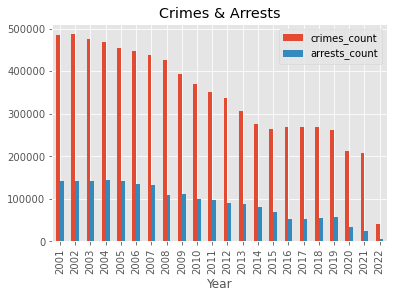

In [25]:
import pandas as pd
df = py_arrest_rate.set_index('Year')

df[["crimes_count", "arrests_count"]].plot.bar()
plt.title('Crimes & Arrests');

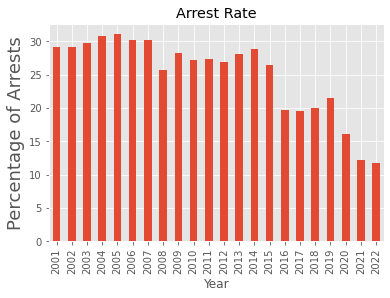

In [26]:
df['arrest_rate'].plot.bar()
plt.title('Arrest Rate')
plt.ylabel("Percentage of Arrests", fontsize = 18);

### Histograms
In the following we will plot a histogram using Spark's aggregation. 

Let's aggregate the data first:

In [27]:
hists = crimes.where("Lat > 37").select("Lat").rdd.flatMap(
    lambda row: row
).histogram(50)

To plot the histogram, you can simply call *matplotlib*, as shown in the cell below:

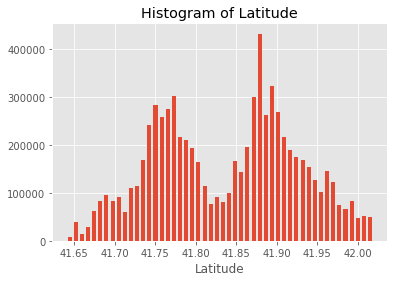

In [28]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

plt.bar(data['bins'], data['freq'], width=.005)
plt.xlabel("Latitude")
plt.title('Histogram of Latitude');

In [29]:
hists = crimes.where("Lon > -90").select("Lon").rdd.flatMap(
    lambda row: row
).histogram(50)

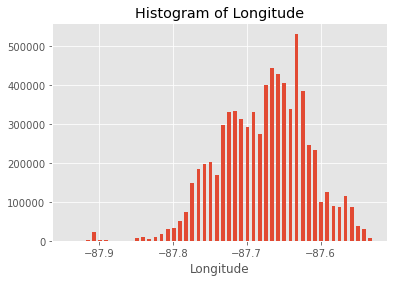

In [30]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

plt.bar(data['bins'], data['freq'], width=.005)
plt.xlabel("Longitude")
plt.title('Histogram of Longitude');

## Line Plot
Number of crimes by month:

In [31]:
crimes_for_each_month = crimes.groupBy(F.month("Date").alias("Month")).agg(F.count("ID").alias("crimes_count")).orderBy("Month")

# Convert to Pandas
py_crimes_for_each_month = crimes_for_each_month.toPandas()
py_crimes_for_each_month.head()

,Month,crimes_count
0,1,600255
1,2,528677
2,3,621371
3,4,608799
4,5,662416


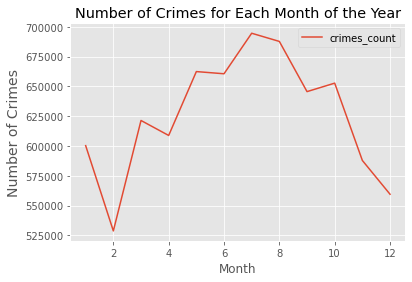

In [32]:
df = py_crimes_for_each_month.set_index('Month')
df.plot.line()
plt.ylabel("Number of Crimes", fontsize = 14)
plt.title('Number of Crimes for Each Month of the Year');

In [33]:
crimes_per_month = crimes.groupBy(F.date_format(F.col("Date"), 'yyyy-MM').alias("Date")).agg(F.count("ID").alias("crimes_count")).orderBy("Date")

# Convert to Pandas
py_crimes_per_month = crimes_per_month.toPandas()
py_crimes_per_month.head()

,Date,crimes_count
0,2001-01,38110
1,2001-02,33783
2,2001-03,40562
3,2001-04,40085
4,2001-05,41832


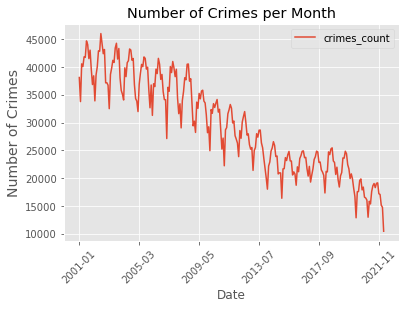

In [34]:
df = py_crimes_per_month.set_index('Date')
df.plot.line()
plt.xticks(rotation=45)
plt.ylabel("Number of Crimes", fontsize = 14)
plt.title('Number of Crimes per Month');

## Sampling & Scatterplot
In the following cell we sample 0.1% of the data to plot a scatterplot:

In [35]:
crimes_sample = crimes.sample(withReplacement = False, fraction = 0.005, seed = 42)

# Convert to Pandas
py_crimes_sample = crimes_sample.toPandas()

py_crimes_sample.head()

,ID,Date,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Beat,District,Ward,CommunityArea,FBICode,Lat,Lon
0,11107098,2017-10-03 09:26:00,040XX W 24TH ST,THEFT,$500 AND UNDER,STREET,False,False,1013,010,22,30,06,41.847900,-87.725056
1,11430076,2018-08-29 17:59:00,011XX W 57TH ST,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,True,False,0712,007,16,68,24,41.790532,-87.654129
2,11259739,2018-03-16 23:30:00,026XX S KOLIN AVE,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,1031,010,22,30,14,41.843324,-87.733041
3,11254404,2018-03-12 19:33:00,004XX W 71ST ST,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,True,False,0732,007,6,68,15,41.765323,-87.636819
4,1492003,2001-04-19 20:50:00,049XX S FEDERAL ST,BATTERY,AGGRAVATED: OTHER DANG WEAPON,CHA HALLWAY/STAIRWELL/ELEVATOR,False,True,0231,002,None,None,04B,41.804197,-87.627926


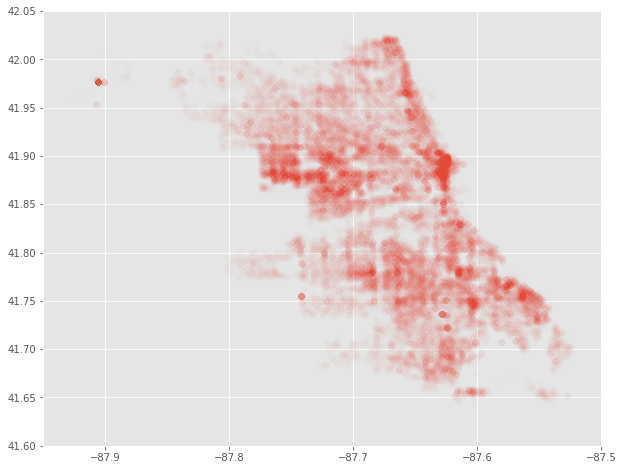

In [45]:
plt.figure(figsize=(10,8))
plt.scatter(py_crimes_sample['Lon'], py_crimes_sample['Lat'], alpha=0.01)
plt.xlim(-87.95, -87.5)
plt.ylim(41.6, 42.05);

<img src="https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/figs/07-01-Chicago.png?raw=true" width="600" align="left"/>

## Further investigations on the dataset
See if you can ask more questions and find answers to those by looking at the data. Here are a few suggestions:

* Where do most crimes take pace?
* Which days have the highest number of crimes?
* Number of domestic crimes by hour?
* Number of 'MOTOR VEHICLE THEFT' from `PrimaryType` column by hour?
* What is the trend of 'LIQUOR LAW VIOLATION' from `PrimaryType` like over the past 10 years?
* Do you see any changes during the COVID-19 pandemic on different crime types? 
    * It is very likely that mandatory quarantines caused increase in dmoestic violence categories and decrease in robbery. Could you find any evidence in the data?

Related EDA work on this dataset:
* https://www.kaggle.com/fahd09/eda-of-crime-in-chicago-2005-2016
* https://datascienceplus.com/spark-dataframes-exploring-chicago-crimes/

In [37]:
# Your answer goes here